# MlOps - Do jupyter ao .py

In [1]:
import joblib
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
print(fetch_california_housing()['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [3]:
X_house, y_house = fetch_california_housing(return_X_y=True, as_frame=True)

In [4]:
X_house['AvgBedsPerRoom'] = X_house['AveBedrms']/X_house['AveRooms']

In [5]:
X_house.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,AvgBedsPerRoom
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,0.213075
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,0.058023
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.100000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,0.175426
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,0.203181
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,0.239834
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,1.000000


## Separando em treino e teste

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_house, y_house, test_size=0.3, random_state=42)

## Criando Pipelines

### Data Leakege

![Train Test](https://www.upgrad.com/blog/wp-content/uploads/2020/01/data-preprocessing-machine-learning-5.png)

#### Por que usar pipelines?

##### Qual o problema nesse trecho?

```python
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_house, y_house = fetch_california_housing(return_X_y=True, as_frame=True)
X_house_scaler = scaler.fit_transform(X_house)
X_train, X_test, y_train, y_test = train_test_split(
    X_house_scaler, y_house, test_size=0.3, random_state=42)
```

##### Podemos resolver parcialmente da seguinte forma:

```python
scaler = MinMaxScaler()
X_house, y_house = fetch_california_housing(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(
    X_house, y_house, test_size=0.3, random_state=42)

X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.fit_transform(X_test)

joblib.dump(X_train_scaler, "../model/scaler.gzip", compress="gzip")

```

Quais os pontos negativos dessa solução?

### Usando Pipelines

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


features_to_transform = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
                         'AveOccup', 'Latitude', 'Longitude', 'AvgBedsPerRoom']

# Definindo os passos que ocorreram pra a transformação
transformer = Pipeline(
    steps=[("standard_scaler", StandardScaler())]
)

# Definindo em quais colunas a transformação será aplicada
preprocessor = ColumnTransformer(
    transformers=[
        ("std", transformer, features_to_transform),
    ]
)

# Criando Pipeline
linear_regressor = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", LinearRegression())]
)

random_forest = Pipeline(
    steps=[("preprocessor", preprocessor),("model", RandomForestRegressor())]
)

In [8]:
import numpy as np

In [9]:
def select_best_model(
    models: list, X: pd.DataFrame, y: pd.DataFrame, cv: int = 3, scoring: str = "r2"
) -> Pipeline:
    """Seleciona o modelo que obtiver o melhor score

    Args:
        models (list): lista contendo os modelos
        X (pd.DataFrame): Matriz de features para treino
        y (pd.DataFrame): Variável resposta
        cv (int, optional): Número de validações cruzadas. Defaults to 3.
        scoring (str, optional): Forma de scorar o modelo. Defaults to "r2".

    Returns:
        sklearn.pipeline.Pipeline: Pipeline do modelo
    """
    scores = []
    for model in models:
        scores.append(
            cross_val_score(model, X, y, cv=cv, scoring=scoring).mean()
        )

    best_model_position = np.array(scores).argmax()
    return models[best_model_position]


In [10]:
%%time
model = select_best_model([linear_regressor, random_forest], X_train, y_train)

CPU times: user 12 s, sys: 2.18 s, total: 14.2 s
Wall time: 11.6 s


In [11]:
from sklearn import set_config
set_config(display="diagram")

In [12]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('std',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['MedInc', 'HouseAge',
                                                   'AveRooms', 'AveBedrms',
                                                   'Population', 'AveOccup',
                                                   'Latitude', 'Longitude',
                                                   'AvgBedsPerRoom'])])),
                ('model', RandomForestRegressor())])

#### Documentação
[Pipelines](https://scikit-learn.org/stable/modules/compose.html)

[ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)

## Fit e score

In [13]:
from matplotlib import pyplot as plt

In [14]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("model score: %.3f" % model.score(X_test, y_test))

model score: 0.804


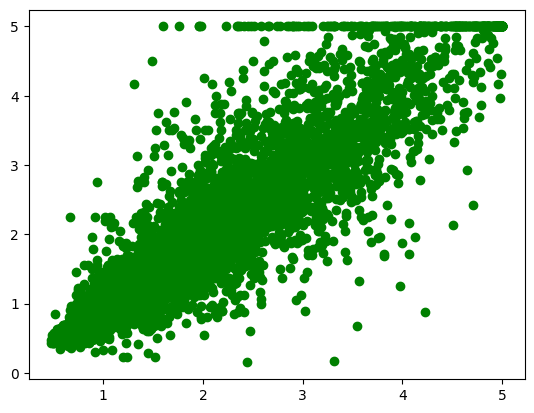

In [15]:
plt.scatter(y_pred, y_test, color='g')
plt.show()

## Salvando o modelo

In [16]:
%pwd

'/Users/gabriel.soares/Desktop/Projects/Personal/Tera-MlOpsProject'

In [17]:
model_path = "regressor.gzip"

In [18]:
# Salvando o Modelo
joblib.dump(model, model_path, compress="gzip")

['regressor.gzip']

In [19]:
joblib.load(model_path).predict(X_test.iloc[0:1,:])[0]*100000

47672.0